In [1]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

/scratch/local/28973376/ipykernel_3934131/2258313207.py:1: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/scratch/local/28973376/ipykernel_3934131/2258313207.py:1: DeprecationWarning: `photutils.EPSFBuilder` is a deprecated alias for `photutils.psf.EPSFBuilder` and will be removed in the future. Instead, please use `from photutils.psf import EPSFBuilder` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/scratch/local/28973376/ipykernel_3934131/2258313207.py:1: DeprecationWarning: `photutils.find_peaks` is a deprecated alias for `photutils.detection.find_peaks` and will be removed in the future. Instead, please use `from photutils.detection import find_p

In [2]:
from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D
from astropy.modeling.fitting import LevMarLSQFitter

In [3]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [4]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy.io import fits
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

In [5]:
import regions
from astropy.io import fits

In [6]:
from photutils import background

In [13]:
from glob import glob

In [7]:
basepath = '/blue/adamginsburg/adamginsburg/jwst/cloudc/'

In [8]:
fh = fits.open(f'{basepath}/F2550W/pipeline/jw02221-o001_t001_miri_f2550w_i2d.fits')
ww = WCS(fh[1].header)

Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [15]:
glob(f'{basepath}/regions_/*miri*')

['/blue/adamginsburg/adamginsburg/jwst/cloudc//regions_/miri-2.reg',
 '/blue/adamginsburg/adamginsburg/jwst/cloudc//regions_/miri-5.reg',
 '/blue/adamginsburg/adamginsburg/jwst/cloudc//regions_/miri-1.reg',
 '/blue/adamginsburg/adamginsburg/jwst/cloudc//regions_/miri-4.reg',
 '/blue/adamginsburg/adamginsburg/jwst/cloudc//regions_/miri-3.reg']

In [18]:
#reg, = regions.Regions.read(f'{basepath}/regions_/cluster_square.reg')

# Jan 15, 2023: redo on different subregion
#reg, = regions.Regions.read(f'{basepath}/regions_/leftside_brick_rezoom.reg')
reglist = [regions.Regions.read(fn)[0] for fn in glob(f'{basepath}/regions_/*miri*')]
reglist

[<RectangleSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
     (266.58084079, -28.58129463)>, width=14.8122 arcsec, height=14.1626 arcsec, angle=0.0 deg)>,
 <RectangleSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
     (266.58884082, -28.59211031)>, width=22.6081 arcsec, height=19.3598 arcsec, angle=0.0 deg)>,
 <RectangleSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
     (266.56676872, -28.57932655)>, width=33.0026 arcsec, height=30.2741 arcsec, angle=0.0 deg)>,
 <RectangleSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
     (266.58146849, -28.58772742)>, width=26.2462 arcsec, height=30.2741 arcsec, angle=0.0 deg)>,
 <RectangleSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
     (266.554497, -28.59585164)>, width=18.4503 arcsec, height=17.2809 arcsec, angle=0.0 deg)>]

In [19]:
figsize = (14, 8) # for 3
figsize = (14, 12) # for 4

In [20]:
def compare_methods(npix=5, figsize=(15, 11), reglist=reglist, ww=ww, data=fh[1].data, resid_estimator=background.MedianBackground):
    # compare background estimators
    pl.figure(figsize=figsize)
    for jj, reg in enumerate(reglist):

        preg = reg.to_pixel(ww)
        mask = preg.to_mask()
        cutout = mask.cutout(data)
        #errcutout = mask.cutout(fh[2].data)
        #weight = mask.cutout(fh[('WHT', 1)].data)
        #cutout_slcs,_ = mask.get_overlap_slices(fh[1].data.shape)
        ncols = 6
        ax = pl.subplot(len(reglist), ncols, jj*ncols+1)
        ax.imshow(cutout, norm=simple_norm(cutout, stretch='log', max_percent=99.5, min_percent=0.05))
        ax.set_title("Data")
        
        ax = pl.subplot(len(reglist), ncols, jj*ncols+2)
        bkg_est = Background2D(cutout, npix, bkg_estimator=resid_estimator())
        resid = cutout-bkg_est.background
        ax.imshow(resid, norm=simple_norm(resid, stretch='log', max_percent=99.5, min_percent=0.05))
        ax.set_title('Resid\n'+str(resid_estimator).split("'")[1].split(".")[-1])
        
        for ii, bkg in enumerate((background.SExtractorBackground, background.MeanBackground, background.MedianBackground, background.MMMBackground)):
            ax = pl.subplot(len(reglist), ncols, ii+jj*ncols+3)
            bkg_est = Background2D(cutout, npix, bkg_estimator=bkg())
            if ii == 0:
                norm = simple_norm(bkg_est.background, stretch='asinh')
                if 'text' in reg.meta:
                    ax.set_ylabel(reg.meta['text'])
            ax.imshow(bkg_est.background, norm=norm)
            ax.set_title(str(bkg).split("'")[1].split(".")[-1])
    pl.tight_layout()
    pl.suptitle(f"npix={npix}");

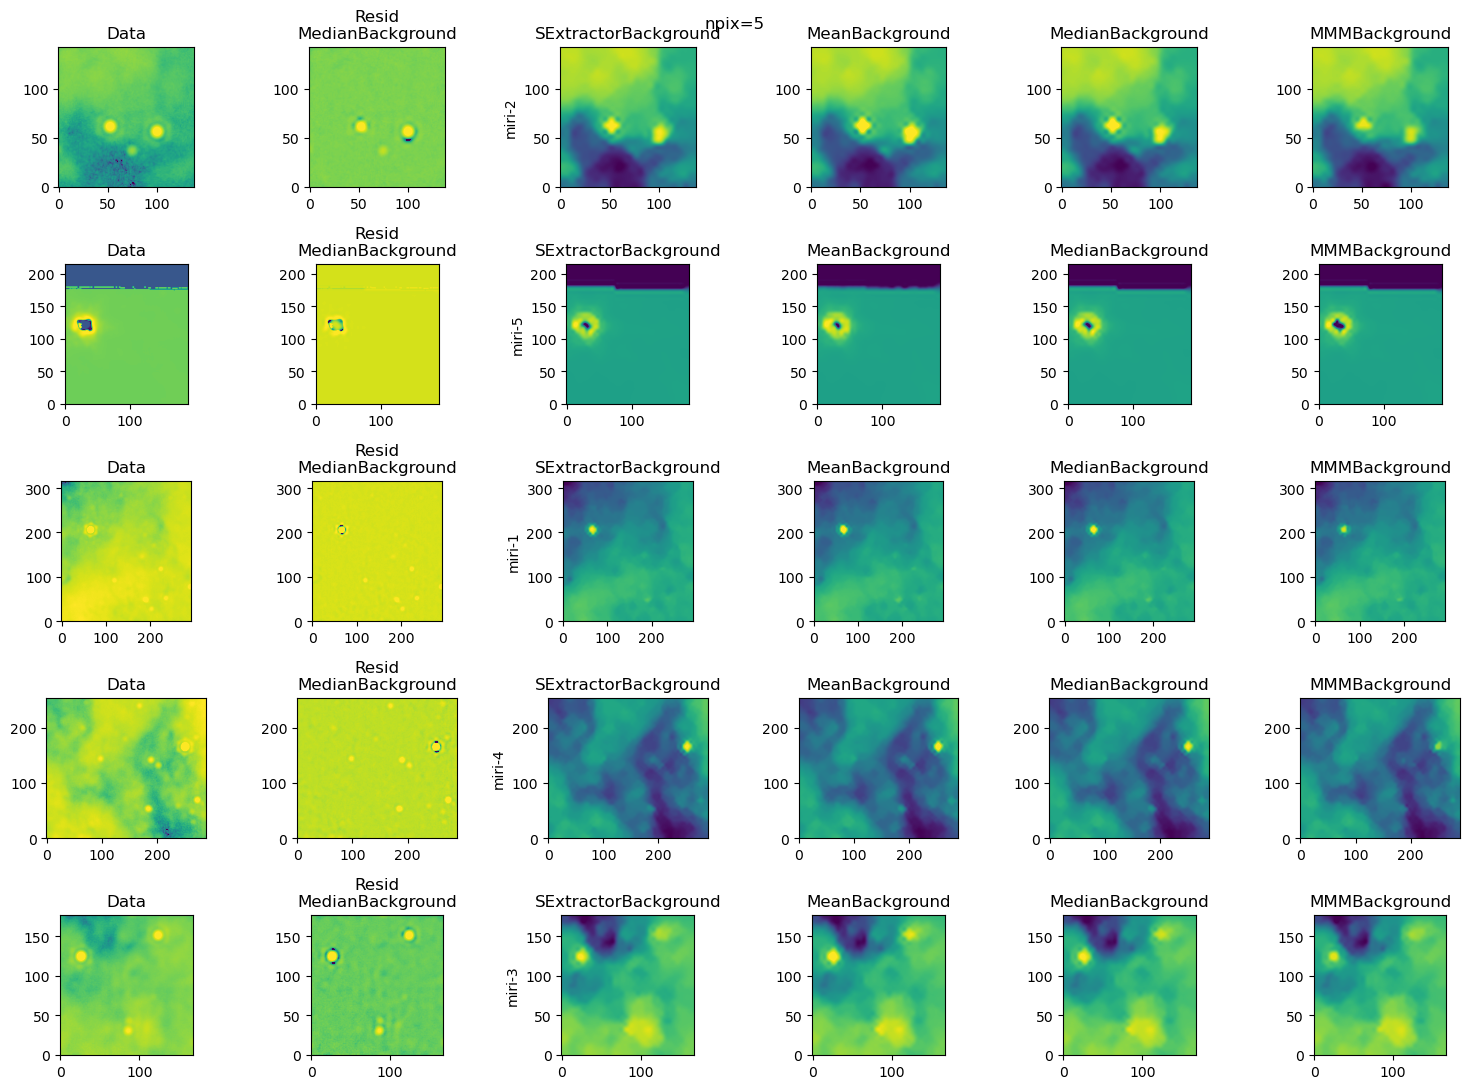

In [21]:
compare_methods(npix=5)

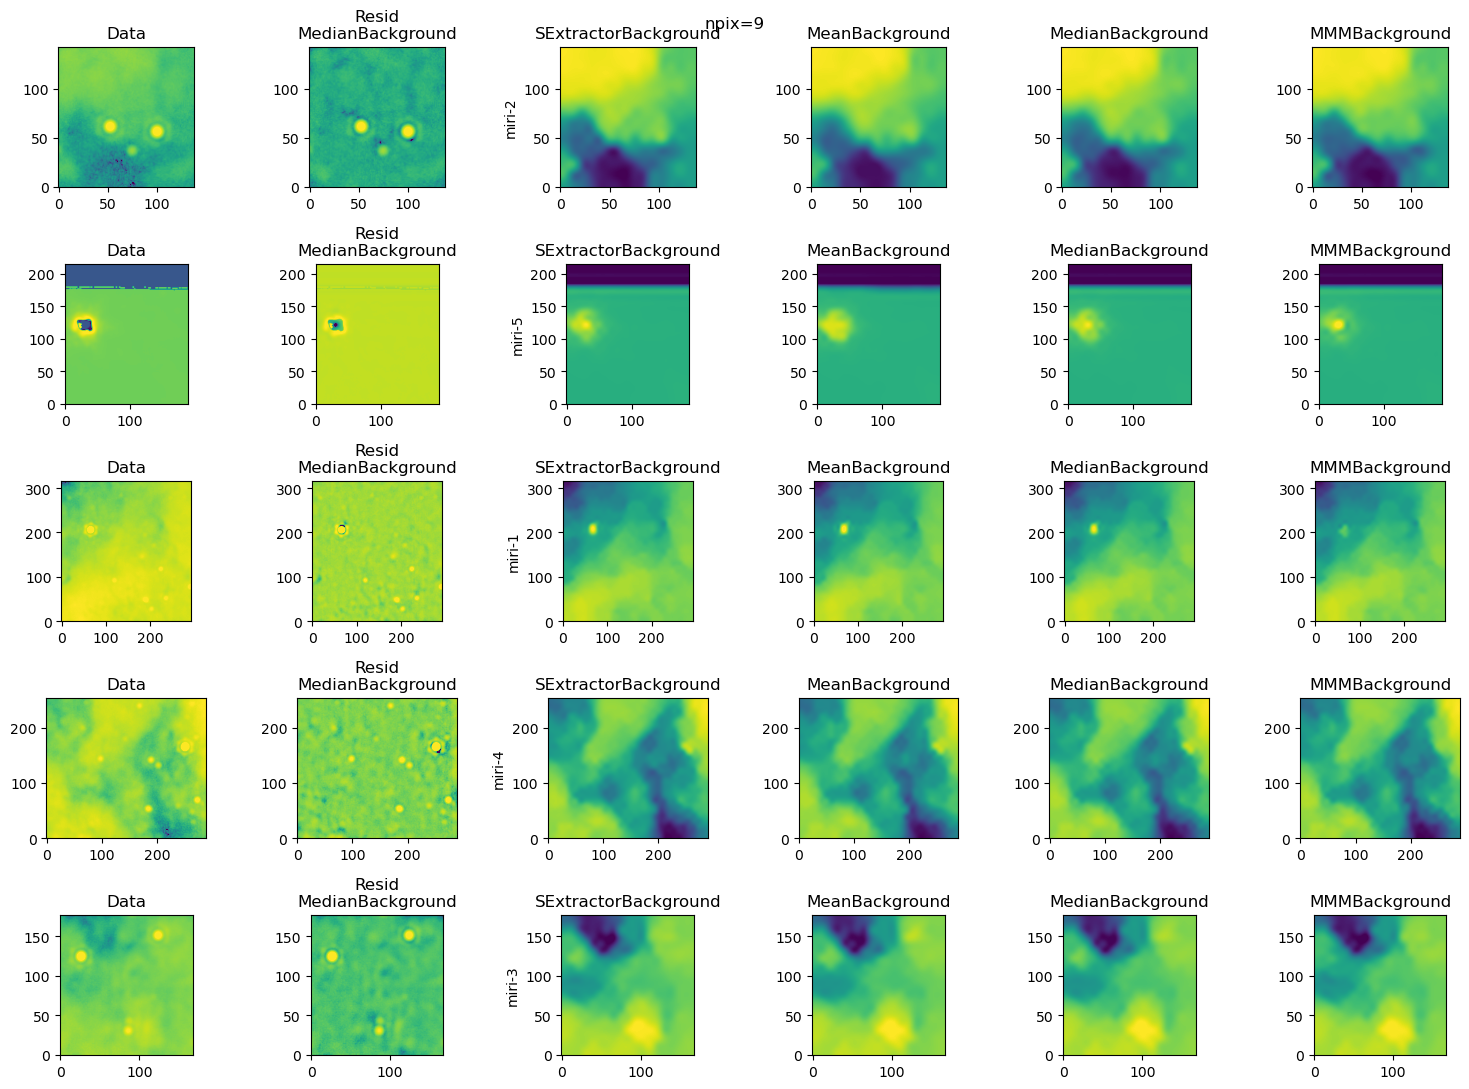

In [22]:
compare_methods(npix=9)

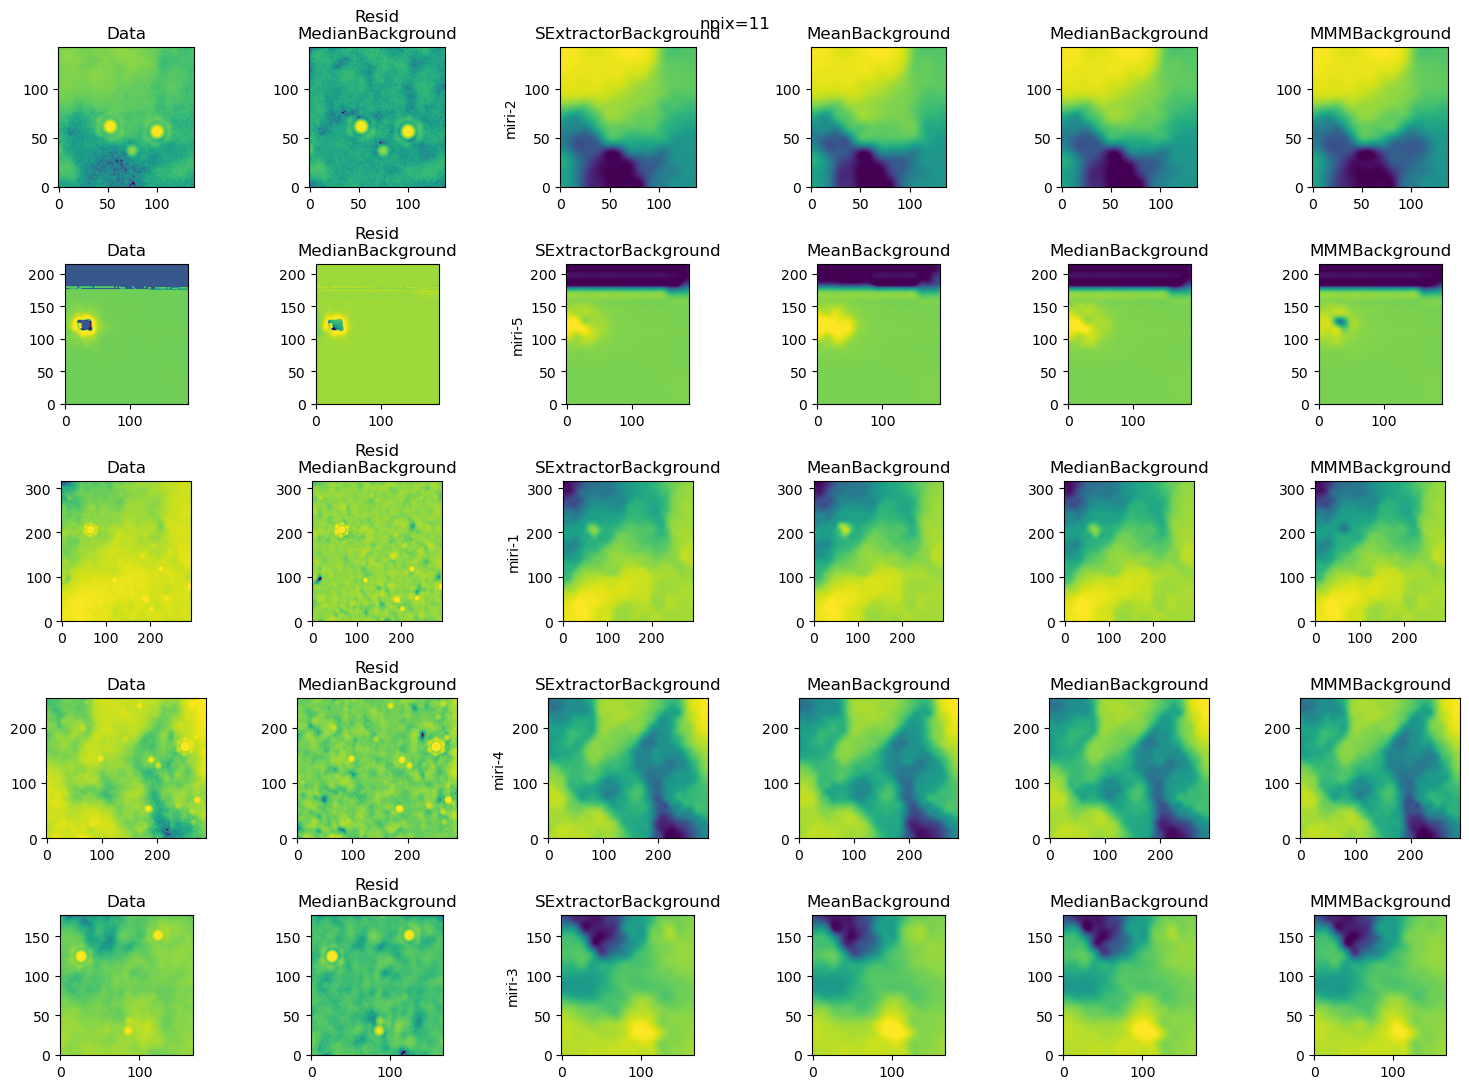

In [23]:
compare_methods(npix=11)

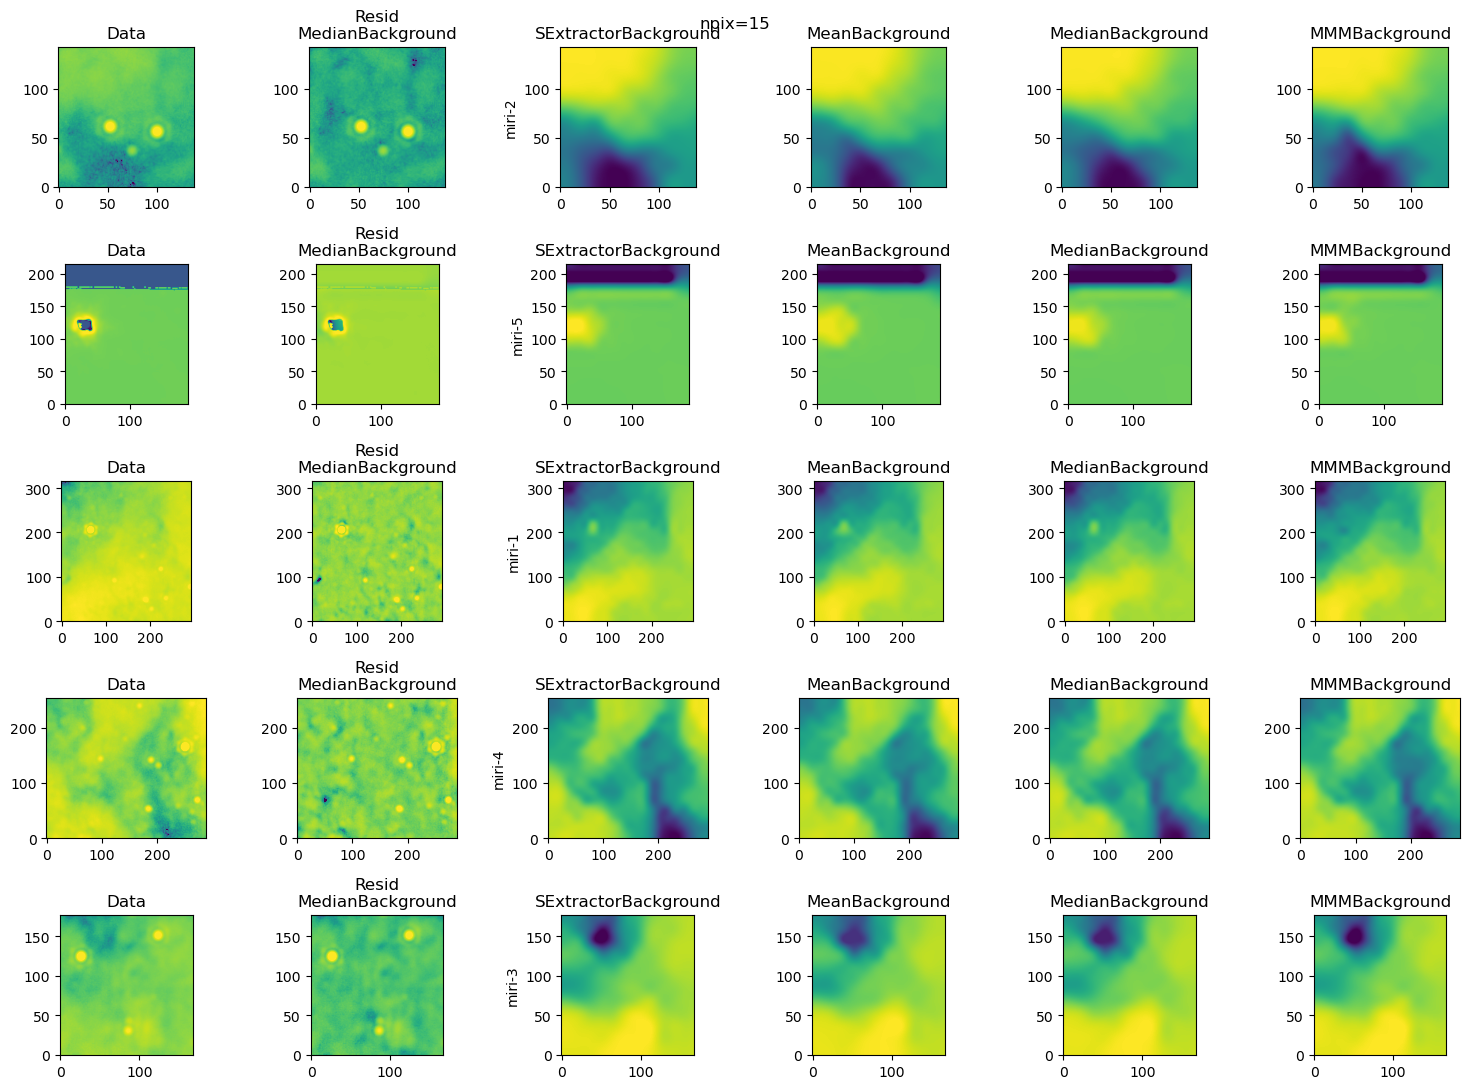

In [24]:
compare_methods(npix=15)

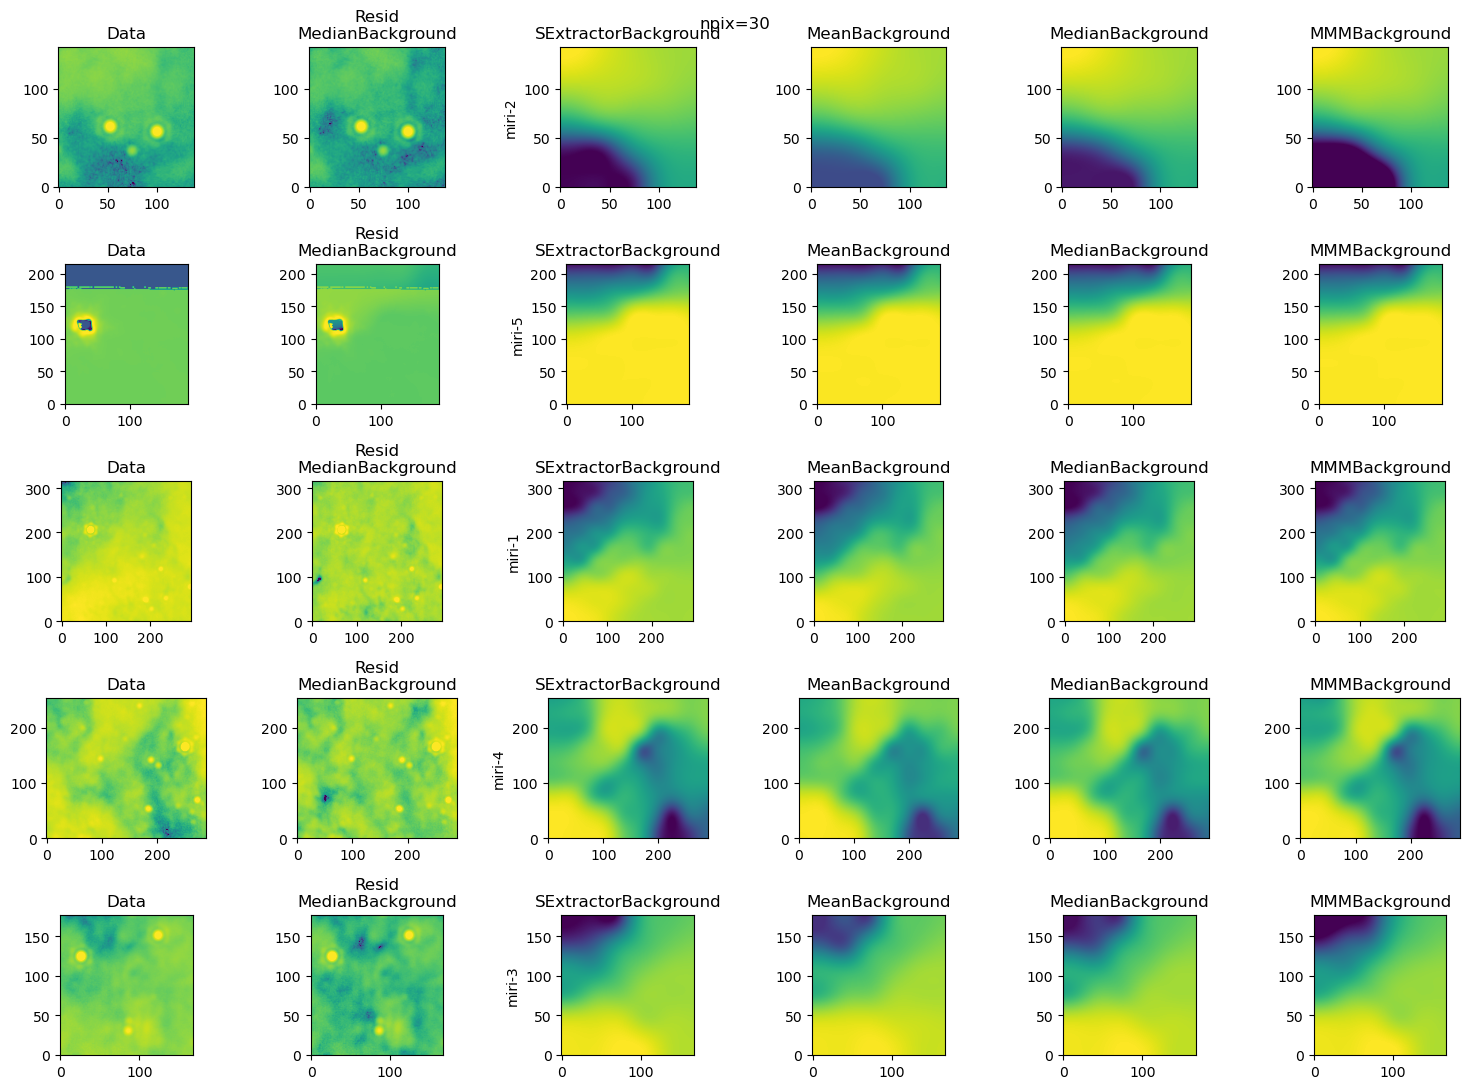

In [25]:
compare_methods(npix=30)

# F405N

In [130]:
fh405 = fits.open(f'{basepath}/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-merged_i2d.fits')
ww405 = WCS(fh405[1].header)

Set OBSGEO-B to   -20.697594 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526831525.846 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


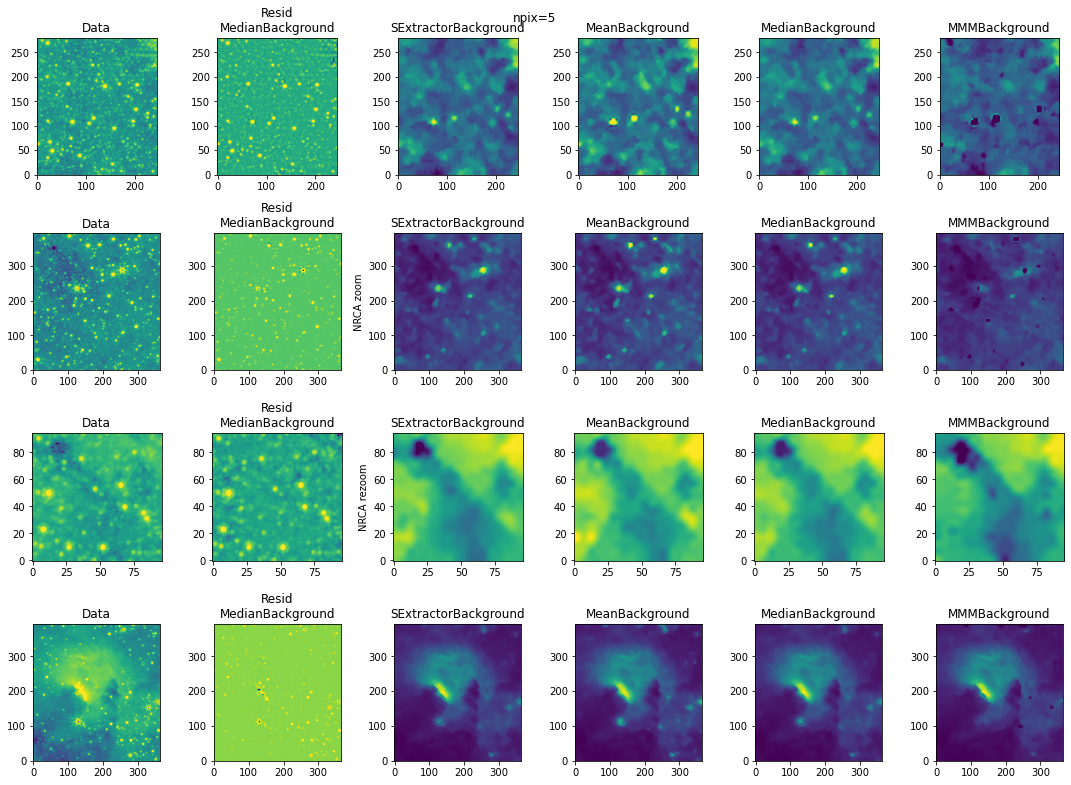

In [131]:
compare_methods(npix=5, ww=ww405, data=fh405['SCI'].data)

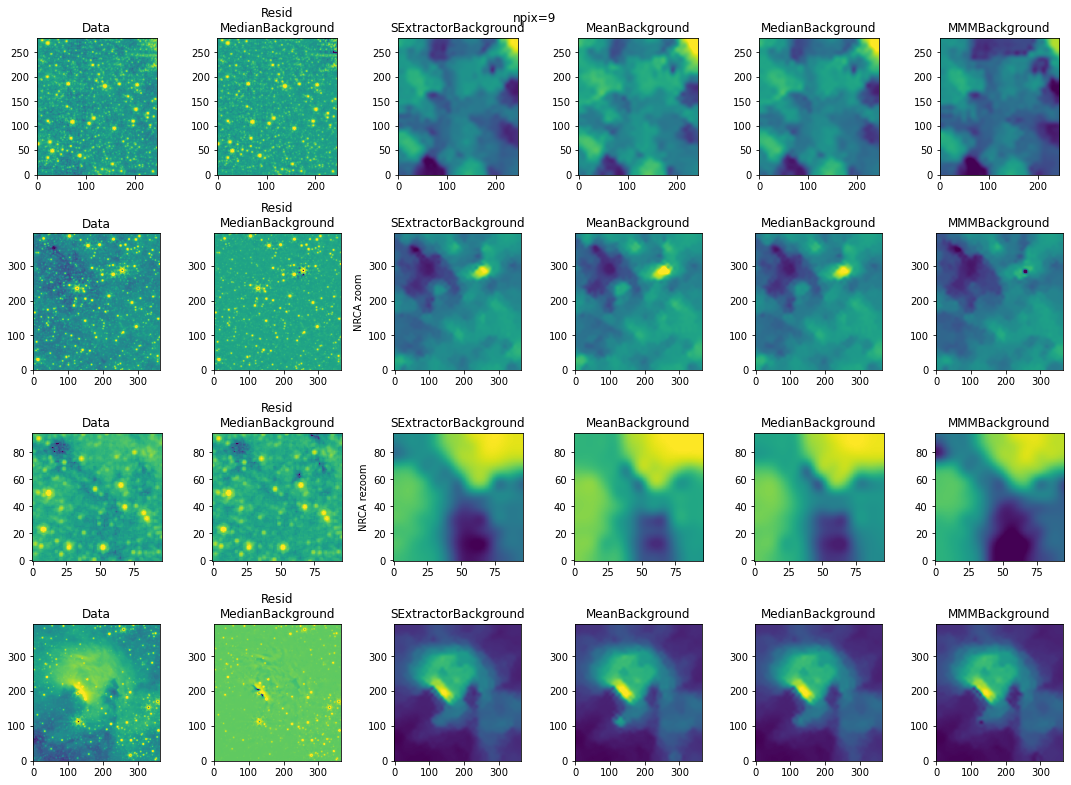

In [132]:
compare_methods(npix=9, ww=ww405, data=fh405['SCI'].data)

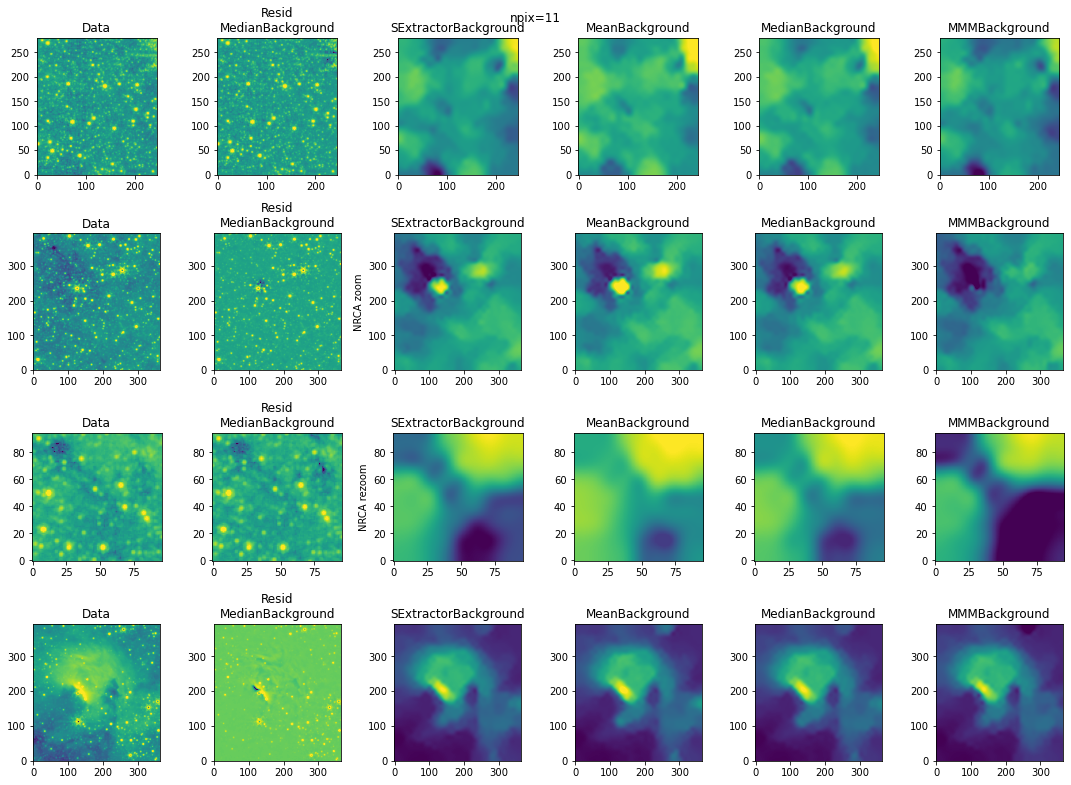

In [133]:
compare_methods(npix=11, ww=ww405, data=fh405['SCI'].data)

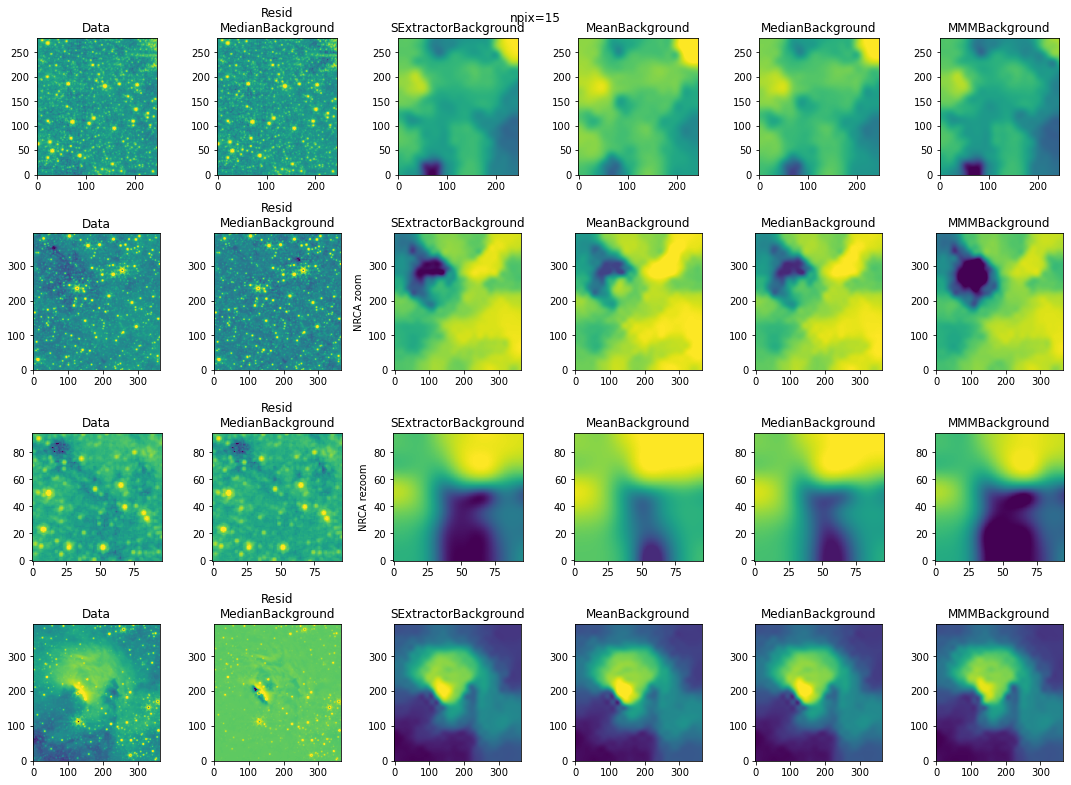

In [134]:
compare_methods(npix=15, ww=ww405, data=fh405['SCI'].data)

In [135]:
fh466 = fits.open(f'{basepath}/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-merged_i2d.fits')
ww466 = WCS(fh466[1].header)

Set OBSGEO-B to   -20.664510 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526442456.371 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


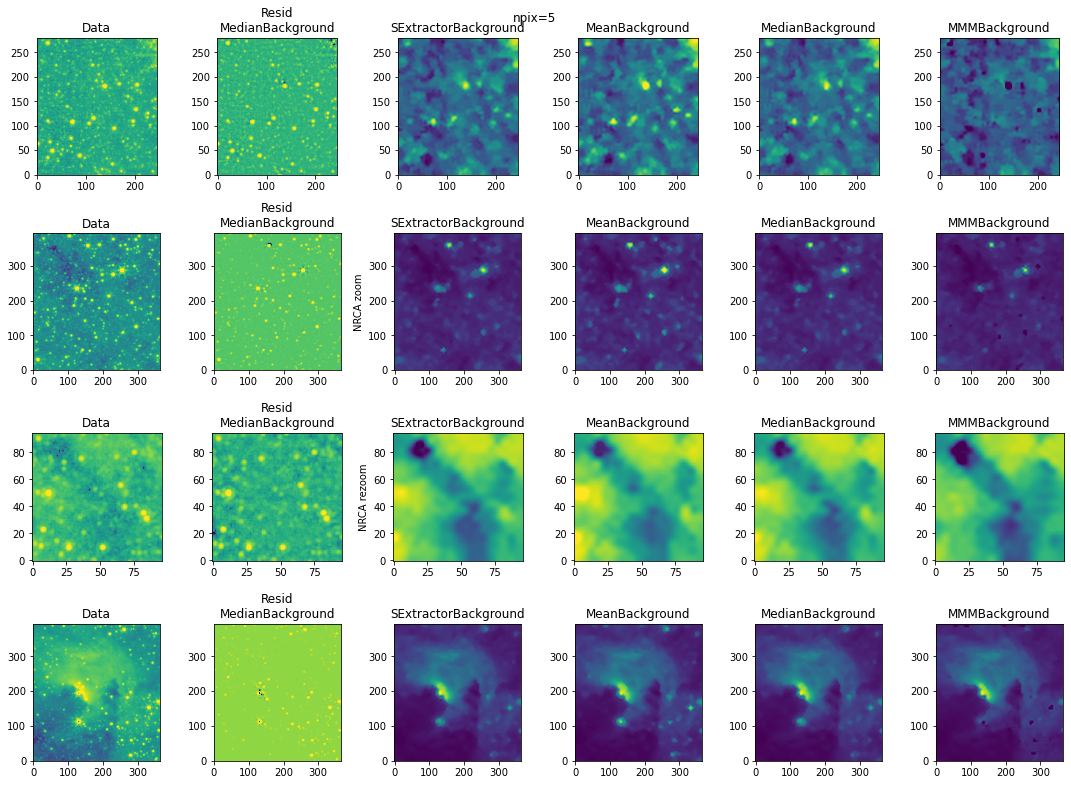

In [136]:
compare_methods(npix=5, ww=ww466, data=fh466['SCI'].data)

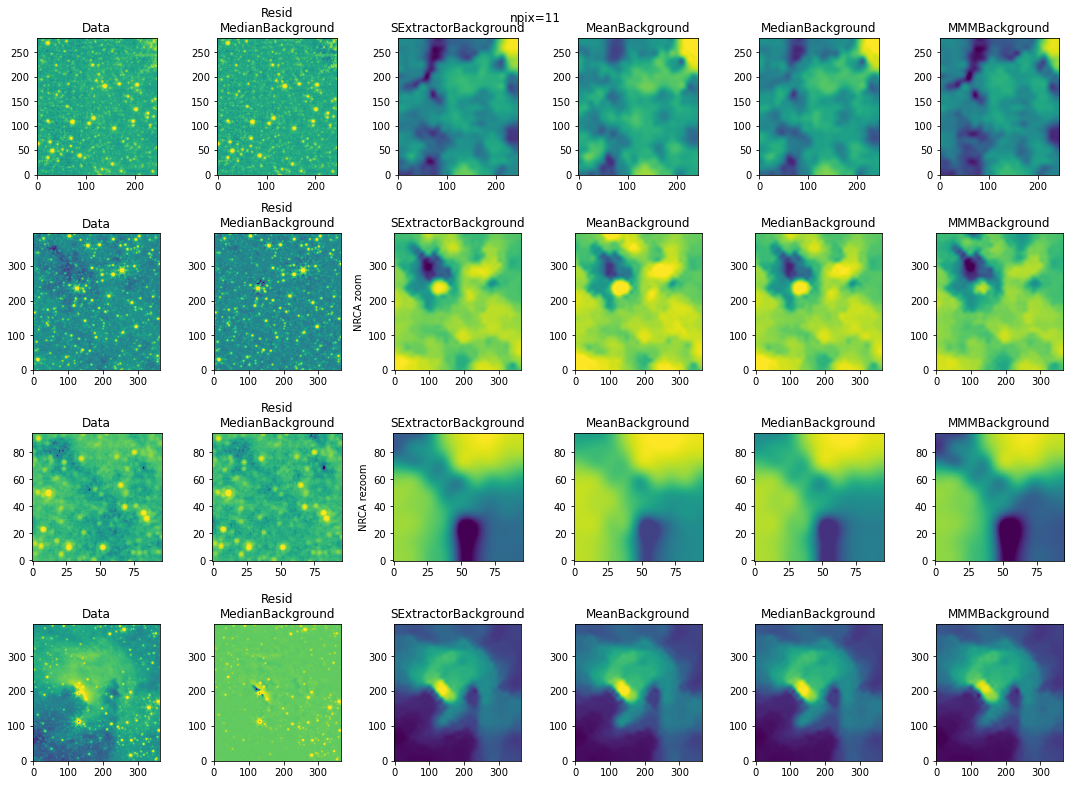

In [137]:
compare_methods(npix=11, ww=ww466, data=fh466['SCI'].data)